<a href="https://colab.research.google.com/github/yanirasilva-star/ICD/blob/main/TG3_ICD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Trabajo grupal 3 — Modelado Predictivo de la Inflación Subyacente
El objetivo de este trabajo es evaluar la capacidad predictiva de distintos modelos estadísticos y de machine learning
para estimar la inflación subyacente interanual en el Perú, utilizando variables macroeconómicas y de política monetaria.
El análisis tiene un enfoque **predictivo**, no inferencial.


## 0. Librerías, semilla y reproducibilidad

In [3]:
import numpy as np, pandas as pd, os, warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

import matplotlib.pyplot as plt, seaborn as sns
sns.set(style='whitegrid', context='talk')

import sklearn, statsmodels
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scikit-learn', sklearn.__version__)
print('statsmodels', statsmodels.__version__)


numpy 2.0.2
pandas 2.2.2
scikit-learn 1.6.1
statsmodels 0.14.5


## 1. Carga y preparación de datos

In [4]:
csv_path = '/content/T1_ICD.csv'
if not os.path.exists(csv_path):
    alt = '/mnt/data/T1_ICD.csv'
    if os.path.exists(alt):
        csv_path = alt
    else:
        raise FileNotFoundError('CSV no encontrado en rutas esperadas.')

df = pd.read_csv(csv_path)
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
df = df.sort_values('Fecha').reset_index(drop=True)
df.set_index('Fecha', inplace=True)
print('Dimensiones:', df.shape)
df.head()

Dimensiones: (152, 10)


,Tasa_Ref (%),Tasa_Depositos_Overnight (%),Inflación_Mensual_Subyacente_12m (%),Expectativas_Inflacion_12m (%),CDBCR_Total_Saldo (S/ millones),CDBCR_Saldo_TIR (%),Repos_Valores (S/ millones),Depositos_Publicos_Saldo (S/ millones),Depositos_Overnight_BCR (S/ miles),Tasa_Interbancaria (%)
Fecha,,,,,,,,,,
2013-01-01,4.25,3.45,2.591667,3.338063,36762.4,4.053,0.0,0.0,367807.0,4.1518
2013-02-01,4.25,3.45,2.575000,3.221990,36200.2,4.030,0.0,0.0,47590.0,4.2008
2013-03-01,4.25,3.45,2.562500,3.477736,36034.7,3.960,0.0,0.0,201773.0,4.2404
2013-04-01,4.25,3.45,2.483333,3.404137,37175.0,3.970,0.0,0.0,122430.0,4.2005
2013-05-01,4.25,3.45,2.479167,3.318773,33493.0,3.860,0.0,0.0,23520.0,4.2542


##Visualización descriptiva de series

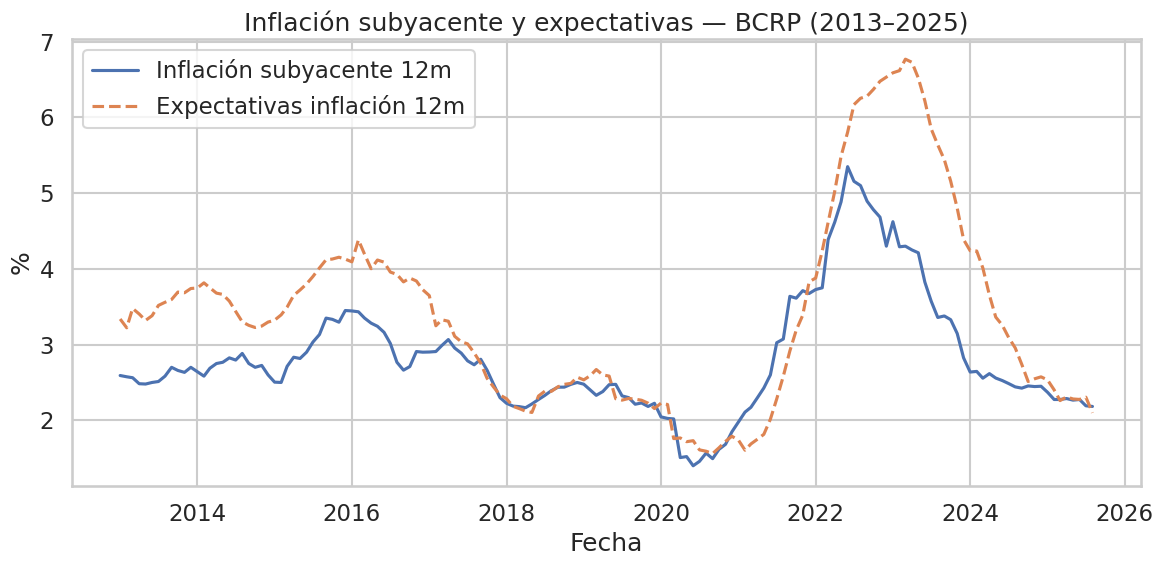

In [5]:
plt.figure(figsize=(12,6))

# Línea continua
sns.lineplot(
    x=df.index,
    y=df['Inflación_Mensual_Subyacente_12m (%)'],
    label='Inflación subyacente 12m',
    linestyle='-'
)

# Línea punteada
sns.lineplot(
    x=df.index,
    y=df['Expectativas_Inflacion_12m (%)'],
    label='Expectativas inflación 12m',
    linestyle='--'
)

plt.title('Inflación subyacente y expectativas — BCRP (2013–2025)')
plt.xlabel('Fecha')
plt.ylabel('%')
plt.legend()
plt.tight_layout()
plt.show()


El gráfico muestra la naturaleza de las expectativas de inflación encuestadas: los agentes actualizan lentamente su percepción del futuro, de modo que las expectativas capturan más la tendencia que las fluctuaciones mensuales.

## 2. Construcción del problema supervisado

In [6]:
target_col = 'Inflación_Mensual_Subyacente_12m (%)'
expect_col = 'Expectativas_Inflacion_12m (%)'
tir_col = 'Tasa_Ref (%)'
monetary_cols = ['CDBCR_Total_Saldo (S/ millones)', 'CDBCR_Saldo_TIR (%)', 'Depositos_Publicos_Saldo (S/ millones)']

for lag in range(1,4):
    df[f'inflacion_12m_lag{lag}'] = df[target_col].shift(lag)
df['Expectativas_Inflacion_12m_lag1'] = df[expect_col].shift(1)
for lag in range(0,4):
    df[f'TIR_lag{lag}'] = df[tir_col].shift(lag)
for col in monetary_cols:
    df[f'{col}_lag1'] = df[col].shift(1)

features = ['inflacion_12m_lag1','inflacion_12m_lag2','inflacion_12m_lag3',
            'Expectativas_Inflacion_12m_lag1','TIR_lag0','TIR_lag1','TIR_lag2','TIR_lag3'] + [f'{c}_lag1' for c in monetary_cols]

missing = [c for c in features + [target_col] if c not in df.columns]
if missing:
    raise ValueError('Faltan columnas: ' + ', '.join(missing))

df_model = df[features + [target_col]].dropna().copy()
print('Observaciones para modelado:', df_model.shape)
df_model.head()

Observaciones para modelado: (149, 12)


,inflacion_12m_lag1,inflacion_12m_lag2,inflacion_12m_lag3,Expectativas_Inflacion_12m_lag1,TIR_lag0,TIR_lag1,TIR_lag2,TIR_lag3,CDBCR_Total_Saldo (S/ millones)_lag1,CDBCR_Saldo_TIR (%)_lag1,Depositos_Publicos_Saldo (S/ millones)_lag1,Inflación_Mensual_Subyacente_12m (%)
Fecha,,,,,,,,,,,,
2013-04-01,2.562500,2.575000,2.591667,3.477736,4.25,4.25,4.25,4.25,36034.7,3.96,0.0,2.483333
2013-05-01,2.483333,2.562500,2.575000,3.404137,4.25,4.25,4.25,4.25,37175.0,3.97,0.0,2.479167
2013-06-01,2.479167,2.483333,2.562500,3.318773,4.25,4.25,4.25,4.25,33493.0,3.86,0.0,2.500000
2013-07-01,2.500000,2.479167,2.483333,3.382053,4.25,4.25,4.25,4.25,33661.1,3.92,0.0,2.512500
2013-08-01,2.512500,2.500000,2.479167,3.517619,4.25,4.25,4.25,4.25,31610.9,3.91,0.0,2.583333



En esta etapa se generó la estructura temporal del modelo supervisado, asegurando la **causalidad económica** mediante el uso de rezagos.  
Cada observación de la inflación subyacente interanual en \( t \) se explica por:

- Sus **propios rezagos** (1 a 3 meses), que capturan la **persistencia inflacionaria**.  
- Las **expectativas de inflación a 12 meses** rezagadas en un período, que reflejan el canal de expectativas.  
- Los **rezagos contemporáneos y pasados de la tasa de referencia (TIR)**, para capturar los efectos de política monetaria.  
- Variables de **liquidez del BCRP** (CD BCRP, tasa de los CD y depósitos públicos), todas en rezago 1, como controles monetarios.

El conjunto final incluye **149 observaciones y 12 variables**, lo que indica una base temporal continua y consistente para estimar la inflación subyacente sin pérdida de información relevante.


## 3. Separación temporal y validación

In [7]:
from sklearn.model_selection import TimeSeriesSplit
n = len(df_model)
test_size = int(np.ceil(0.25 * n))
train_size = n - test_size
train = df_model.iloc[:train_size].copy()
test = df_model.iloc[train_size:].copy()

X_train = train[features]; y_train = train[target_col]
X_test = test[features]; y_test = test[target_col]
print('Train', X_train.shape, 'Test', X_test.shape)

tscv = TimeSeriesSplit(n_splits=5)

Train (111, 11) Test (38, 11)



Se dividió la muestra total en **75% para entrenamiento (111 observaciones)** y **25% para prueba (38 observaciones)**, manteniendo el **orden cronológico** de las series.  
Esto asegura que las observaciones futuras nunca se utilicen para predecir el pasado, preservando la lógica temporal del proceso inflacionario.

Además, se implementó una **validación cruzada temporal (TimeSeriesSplit, 5 pliegues)**, que evalúa la estabilidad de los modelos a lo largo del tiempo y permite estimar su capacidad de generalización en distintos subperíodos.  
Esta metodología es especialmente adecuada para **series macroeconómicas** donde existe dependencia temporal entre observaciones.


## 4. Baselines

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
# Baseline mean
y_pred_base_mean = np.repeat(y_train.mean(), len(y_test))
mse_base_mean = mean_squared_error(y_test, y_pred_base_mean)
r2_base_mean = r2_score(y_test, y_pred_base_mean)
# Baseline persistence
y_pred_persistence = X_test['inflacion_12m_lag1'].values
mse_persistence = mean_squared_error(y_test, y_pred_persistence)
r2_persistence = r2_score(y_test, y_pred_persistence)
print('Baseline mean MSE:', mse_base_mean, 'R2:', r2_base_mean)
print('Baseline persistence MSE:', mse_persistence, 'R2:', r2_persistence)

Baseline mean MSE: 1.226592148295128 R2: -0.29006646247076673
Baseline persistence MSE: 0.024965620431286244 R2: 0.9737424459483593




Se estimaron dos modelos de referencia (baselines) que sirven como punto de comparación para evaluar el desempeño de los modelos supervisados posteriores (OLS, Ridge, RF, XGB):

---

**1️. Modelo baseline de la media**

Este modelo predice la inflación futura suponiendo que será igual al promedio histórico de la inflación observada en el conjunto de entrenamiento:

$ \hat{\pi}_t = \bar{\pi}_{\text{train}} $

En este caso, el resultado fue:
 $ \text{MSE} = 1.2266, \quad R^2 = -0.29 $

El \( R^2 \) negativo indica que el modelo **no explica la variabilidad** de la inflación mejor que una simple media — es decir, se comporta peor que una predicción constante sin estructura temporal.

---

**2️. Modelo baseline de persistencia**

Este modelo asume que la inflación actual será igual a la del mes anterior, lo cual es típico en series macroeconómicas con inercia:

$ \hat{\pi}_t = \pi_{t-1} $

El resultado obtenido fue:
$\text{MSE} = 0.0250, \quad R^2 = 0.97$

Lo anterior evidencia una **fuerte persistencia inflacionaria**: los valores pasados de la inflación subyacente explican casi toda la variabilidad actual, reflejando la naturaleza inercial de la inflación en el Perú.

---

En resumen, cualquier modelo econométrico o de machine learning más complejo deberá **superar el desempeño del modelo de persistencia**, pues este representa un límite mínimo razonable de precisión predictiva.



## 5. OLS (statsmodels) — estimación e inferencia

In [9]:
import statsmodels.api as sm
X_tr_sm = sm.add_constant(X_train)
ols_final = sm.OLS(y_train, X_tr_sm).fit()
display(ols_final.summary())
y_pred_ols = ols_final.predict(sm.add_constant(X_test))
mse_ols_test = mean_squared_error(y_test, y_pred_ols)
r2_ols_test = r2_score(y_test, y_pred_ols)
print('OLS Test MSE: {:.6f}, R2: {:.6f}'.format(mse_ols_test, r2_ols_test))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Inflación_Mensual_Subyacente_12m (%)   R-squared:                       0.972
Model:                                              OLS   Adj. R-squared:                  0.969
Method:                                   Least Squares   F-statistic:                     316.1
Date:                                  Thu, 20 Nov 2025   Prob (F-statistic):           7.05e-72
Time:                                          03:52:43   Log-Likelihood:                 87.890
No. Observations:                                   111   AIC:                            -151.8
Df Residuals:                                        99   BIC:                            -119.3
Df Model:                                            11                                         
Covariance Type:                              nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -0.0639      0.123     -0.517      0.606      -0.309       0.181
inflacion_12m_lag1                              0.9865      0.100      9.817      0.000       0.787       1.186
inflacion_12m_lag2                              0.1496      0.142      1.055      0.294      -0.132       0.431
inflacion_12m_lag3                             -0.2638      0.103     -2.567      0.012      -0.468      -0.060
Expectativas_Inflacion_12m_lag1                 0.1039      0.039      2.653      0.009       0.026       0.182
TIR_lag0                                        0.2141      0.074      2.875      0.005       0.066       0.362
TIR_lag1                                       -0.1171      0.125     -0.933      0.353      -0.366       0.132
TIR_lag2                                       -0.1707      0.128     -1.335      0.185      -0.425       0.083
TIR_lag3                                        0.0659      0.084      0.781      0.437      -0.102       0.233
CDBCR_Total_Saldo (S/ millones)_lag1         2.832e-06   1.39e-06      2.035      0.045    7.09e-08    5.59e-06
CDBCR_Saldo_TIR (%)_lag1                        0.0044      0.047      0.094      0.925      -0.088       0.097
Depositos_Publicos_Saldo (S/ millones)_lag1  1.033e-05   9.06e-06      1.141      0.257   -7.64e-06    2.83e-05
==============================================================================
Omnibus:                       19.154   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.041
Skew:                           0.792   Prob(JB):                     3.00e-07
Kurtosis:                       4.996   Cond. No.                     6.42e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

OLS Test MSE: 0.058149, R2: 0.938842



El modelo OLS constituye la base econométrica del análisis, ya que permite identificar los **determinantes estructurales** de la inflación subyacente interanual mediante una especificación lineal con rezagos y variables monetarias.

Su forma general puede expresarse de manera compacta como:

$
\pi_t = \alpha +
\sum_{i=1}^{3} \beta_i \pi_{t-i} +
\gamma E_{t-1}[\pi_{t+12}] +
\sum_{i=0}^{3} \delta_i \text{TIR}_{t-i} +
\boldsymbol{\theta}' \mathbf{Z}_{t-1} +
\varepsilon_t
$

donde:  
- $\pi_t$: inflación subyacente interanual.  
- $E_{t-1}[\pi_{t+12}]$: expectativas de inflación a 12 meses (rezagadas).  
- $\text{TIR}_{t-i}$: tasa de referencia del BCRP y sus rezagos.  
- $\mathbf{Z}_{t-1}$: vector de controles monetarios (CD BCRP, tasa de CDBCR y depósitos públicos).  
- $\varepsilon_t$: término de error aleatorio.

---

El modelo OLS logra un R² de 0.94 en el conjunto de prueba, confirmando su notable poder de predicción a pesar de su sencillez. Los coeficientes estimados reflejan relaciones económicamente coherentes: la inflación del mes previo ejerce un efecto dominante, reforzando la idea de persistencia; las expectativas de inflación tienen un impacto positivo y estadísticamente significativo, lo que sugiere que las percepciones de los agentes económicos efectivamente se traducen en presiones de precios; y la tasa de referencia actual también aparece con un coeficiente positivo, probablemente reflejando la respuesta de la política monetaria ante presiones inflacionarias.

En conjunto, el OLS logra reproducir con precisión la dinámica inflacionaria sin sobreajustarse, capturando tanto la inercia estructural del proceso como las señales contemporáneas de la política monetaria y las expectativas.


## 6. Diagnóstico de residuos y heterocedasticidad

In [10]:
# Test de heterocedasticidad y autocorrelación
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

bp = het_breuschpagan(ols_final.resid, ols_final.model.exog)
labels = ['LM Stat', 'LM pvalue', 'F Stat', 'F pvalue']
print('Breusch–Pagan:', dict(zip(labels, bp)))
print('Durbin–Watson:', durbin_watson(ols_final.resid))

# Estimación con errores robustos Newey–West (HAC)
ols_nw = ols_final.get_robustcov_results(cov_type='HAC', maxlags=4)
print("\n--- OLS con errores robustos Newey–West ---")
display(ols_nw.summary())


Breusch–Pagan: {'LM Stat': np.float64(24.380998819841718), 'LM pvalue': np.float64(0.011219146566648172), 'F Stat': np.float64(2.5332662162911173), 'F pvalue': np.float64(0.007353254278300434)}
Durbin–Watson: 1.9173720017618188

--- OLS con errores robustos Newey–West ---


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Inflación_Mensual_Subyacente_12m (%)   R-squared:                       0.972
Model:                                              OLS   Adj. R-squared:                  0.969
Method:                                   Least Squares   F-statistic:                     395.7
Date:                                  Thu, 20 Nov 2025   Prob (F-statistic):           1.41e-76
Time:                                          03:52:43   Log-Likelihood:                 87.890
No. Observations:                                   111   AIC:                            -151.8
Df Residuals:                                        99   BIC:                            -119.3
Df Model:                                            11                                         
Covariance Type:                                    HAC                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -0.0639      0.143     -0.447      0.656      -0.348       0.220
inflacion_12m_lag1                              0.9865      0.096     10.321      0.000       0.797       1.176
inflacion_12m_lag2                              0.1496      0.156      0.959      0.340      -0.160       0.459
inflacion_12m_lag3                             -0.2638      0.111     -2.383      0.019      -0.483      -0.044
Expectativas_Inflacion_12m_lag1                 0.1039      0.041      2.520      0.013       0.022       0.186
TIR_lag0                                        0.2141      0.074      2.879      0.005       0.067       0.362
TIR_lag1                                       -0.1171      0.127     -0.922      0.359      -0.369       0.135
TIR_lag2                                       -0.1707      0.101     -1.693      0.094      -0.371       0.029
TIR_lag3                                        0.0659      0.078      0.848      0.398      -0.088       0.220
CDBCR_Total_Saldo (S/ millones)_lag1         2.832e-06    1.7e-06      1.669      0.098   -5.35e-07     6.2e-06
CDBCR_Saldo_TIR (%)_lag1                        0.0044      0.037      0.118      0.906      -0.069       0.078
Depositos_Publicos_Saldo (S/ millones)_lag1  1.033e-05   8.61e-06      1.200      0.233   -6.76e-06    2.74e-05
==============================================================================
Omnibus:                       19.154   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.041
Skew:                           0.792   Prob(JB):                     3.00e-07
Kurtosis:                       4.996   Cond. No.                     6.42e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 4 lags and without small sample correction
[2] The condition number is large, 6.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Los resultados del test de Breusch–Pagan indican cierta heterocedasticidad residual, coherente con la presencia de episodios de mayor volatilidad durante los años de shocks externos. Sin embargo, el estadístico de Durbin–Watson ( aprox 1.9) y la estabilidad del R² muestran que el modelo no sufre autocorrelación seria ni pérdida de capacidad predictiva.

La corrección con errores robustos de Newey–West confirma que la estructura de los coeficientes se mantiene estable, lo cual refuerza la validez del modelo para fines de pronóstico. En términos prácticos, esto significa que las fluctuaciones residuales responden a factores transitorios o exógenos, como por ejemplo: shocks de oferta o movimientos globales, más que a deficiencias estructurales en la especificación.

## 7.1. Multicolinealidad y PCA

,var,VIF
7,TIR_lag2,241.808269
6,TIR_lag1,235.601148
0,const,125.620379
8,TIR_lag3,104.956679
5,TIR_lag0,84.984366
2,inflacion_12m_lag2,54.011341
1,inflacion_12m_lag1,30.789537
10,CDBCR_Saldo_TIR (%)_lag1,29.384236
3,inflacion_12m_lag3,25.260734
4,Expectativas_Inflacion_12m_lag1,9.642051


Varianza explicada (PC1, PC2): [0.80730268 0.13526325]


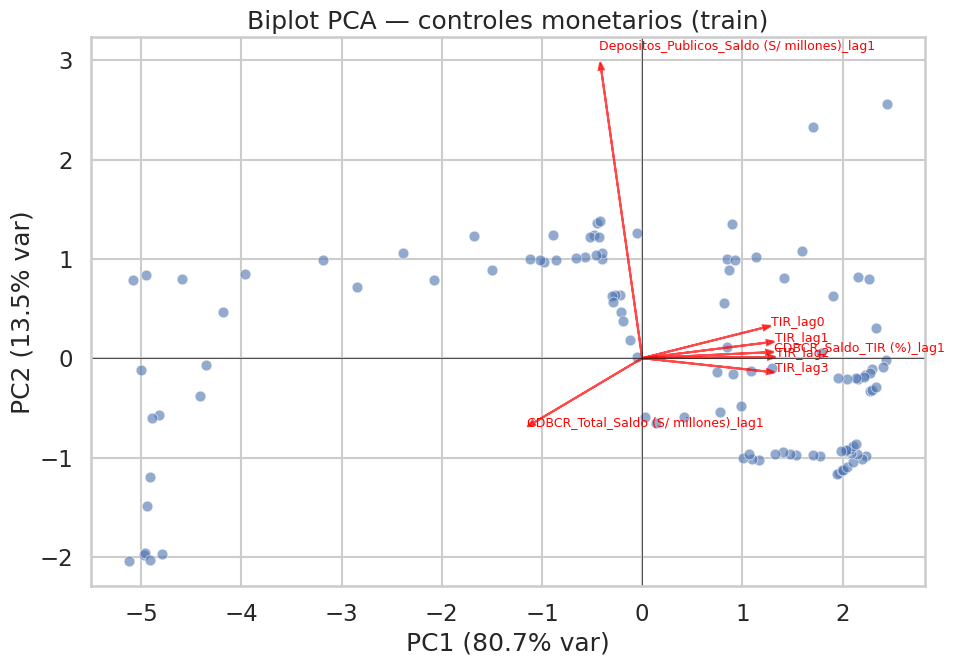

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_vif = sm.add_constant(X_train)
vif = pd.DataFrame({'var': X_vif.columns, 'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])] })
vif = vif.sort_values('VIF', ascending=False)
display(vif)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
monetary_features = [f'{c}_lag1' for c in monetary_cols] + [f'TIR_lag{i}' for i in range(4)]
X_monetary = X_train[monetary_features].dropna()
scaler_pca = StandardScaler().fit(X_monetary)
X_m_s = scaler_pca.transform(X_monetary)
pca = PCA(n_components=2).fit(X_m_s)
pc_scores = pca.transform(X_m_s)
print('Varianza explicada (PC1, PC2):', pca.explained_variance_ratio_)

plt.figure(figsize=(10,7))
sns.scatterplot(x=pc_scores[:,0], y=pc_scores[:,1], alpha=0.6, s=60)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.title('Biplot PCA — controles monetarios (train)')

loadings = pca.components_.T
for i, varname in enumerate(monetary_features):
    plt.arrow(0, 0, loadings[i,0]*3, loadings[i,1]*3, color='red', alpha=0.7, head_width=0.05)
    plt.text(loadings[i,0]*3.2, loadings[i,1]*3.2, varname, color='red', fontsize=9)
plt.axhline(0, color='k', linewidth=0.5); plt.axvline(0, color='k', linewidth=0.5)
plt.tight_layout()
plt.show()

El análisis de multicolinealidad muestra que los distintos rezagos de la tasa de referencia del BCRP presentan valores VIF muy elevados, lo cual indica una fuerte correlación entre ellos. Este resultado no refleja un error de modelado, sino una característica inherente a la política monetaria peruana: el BCRP ajusta su tasa de referencia de manera gradual, generando persistencia en los niveles observados de un mes a otro. En términos económicos, esta consistencia temporal es evidencia de una política monetaria estable y predecible.

El PCA aplicado a las variables monetarias confirma esta relación estructural, pues el primer componente explica más del 80 % de la varianza, representando un factor común que puede interpretarse como la postura general de la política monetaria. Desde un punto de vista descriptivo, esto sugiere que el conjunto de instrumentos del BCRP se mueve de forma coordinada. Sin embargo, el hecho de que estos componentes capturen la varianza no implica necesariamente que mejoren la predicción. Tal como se verificará en la siguiente sección (7.2), al utilizar estos componentes en un modelo predictivo, el rendimiento fuera de muestra se deteriora de manera notable. Ello anticipa que, aunque el PCA permite resumir la información, la compresión elimina parte de la señal temporal que los modelos aprovechan para anticipar la inflación.

### 7.2. PCA extendido: Expectativas y Variables Monetarias del BCRP

En esta sección se aplica PCA a las expectativas de inflación y a los principales instrumentos monetarios del BCRP, con el fin de identificar factores comunes que resuman su variabilidad conjunta.

Se obtienen dos componentes principales (PC1 y PC2), se visualiza su estructura mediante un biplot y luego se utilizan como predictores en un modelo OLS. Finalmente, se compara la inflación real con la predicha por este modelo para evaluar si estos factores latentes aportan capacidad explicativa sobre la inflación subyacente.


Varianza explicada por PC1 y PC2: 56.01% + 27.40% = 83.41%


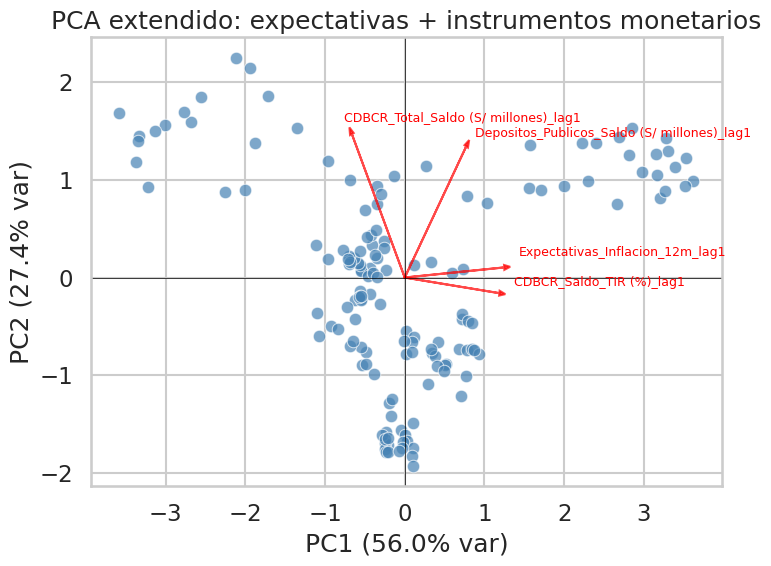

OLS con PCA — MSE test: 1.303175, R² test: -0.370613


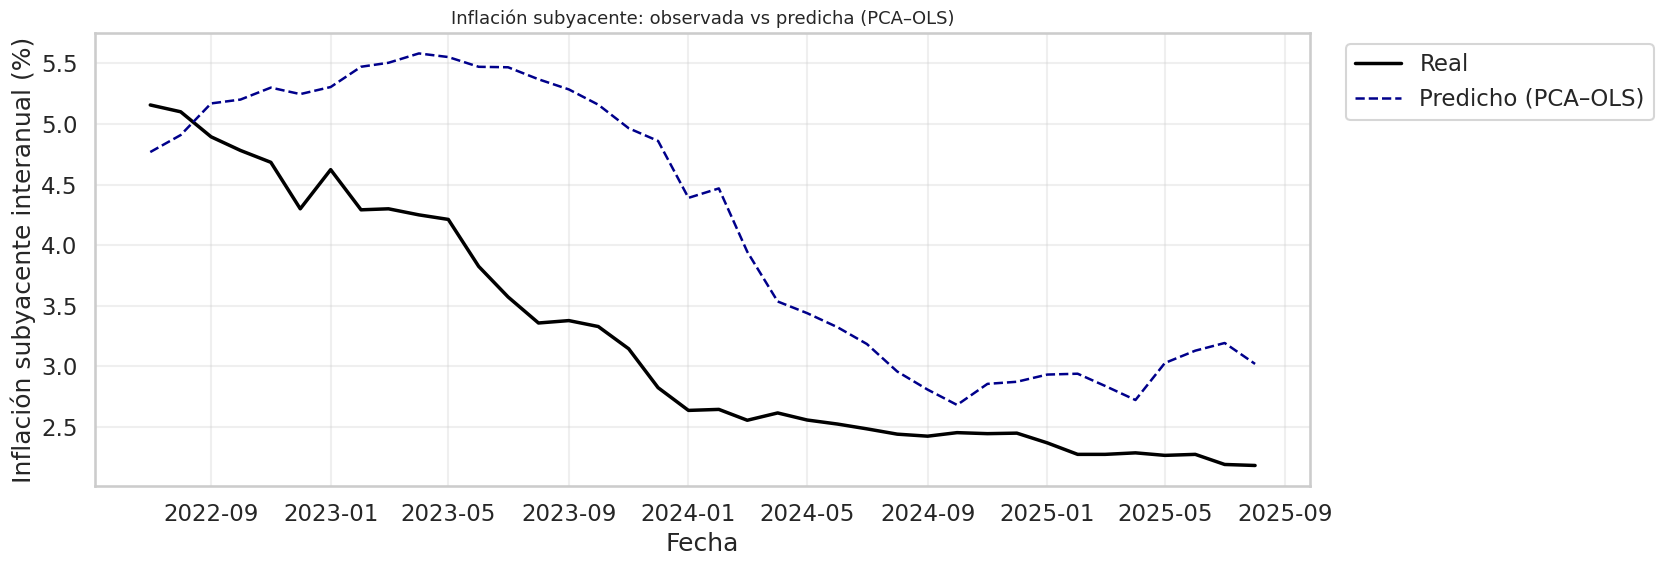

In [12]:
# ============================================================
# 7.2. PCA extendido: expectativas y variables monetarias del BCRP
# ============================================================

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Variables incluidas en el PCA: expectativas + instrumentos del BCRP
pca_vars = [
    'Expectativas_Inflacion_12m_lag1',
    'CDBCR_Total_Saldo (S/ millones)_lag1',
    'CDBCR_Saldo_TIR (%)_lag1',
    'Depositos_Publicos_Saldo (S/ millones)_lag1'
]

# Escalamiento estándar (PCA requiere estandarización)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[pca_vars])

# PCA con dos componentes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada
explained = pca.explained_variance_ratio_
print(f"Varianza explicada por PC1 y PC2: {explained[0]*100:.2f}% + "
      f"{explained[1]*100:.2f}% = {explained.sum()*100:.2f}%")

# DataFrame con los componentes principales
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=df_model.index)

# ------------------------------------------------------------
# Biplot PCA extendido
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, alpha=0.7, color='steelblue')

plt.xlabel(f'PC1 ({explained[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({explained[1]*100:.1f}% var)')
plt.title('PCA extendido: expectativas + instrumentos monetarios')

# Flechas de carga
loadings = pca.components_.T
for i, varname in enumerate(pca_vars):
    x, y = loadings[i,0]*2, loadings[i,1]*2
    plt.arrow(0, 0, x, y, color='red', alpha=0.7, head_width=0.05)

    offset_y = 0.10 if i % 2 == 0 else -0.10
    plt.text(x*1.15, y*1.15 + offset_y, varname, color='red', fontsize=9)

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

# ============================================================
#  Evaluación predictiva SOLO con OLS (PC1 y PC2)
# ============================================================

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

# División temporal coherente con el train/test original
X_train_pca = pca_df.iloc[:train_size]
X_test_pca = pca_df.iloc[train_size:]

y_train_pca = y_train
y_test_pca = y_test

# OLS usando los dos componentes principales
X_train_pca_ols = sm.add_constant(X_train_pca)
X_test_pca_ols = sm.add_constant(X_test_pca)

ols_pca_model = sm.OLS(y_train_pca, X_train_pca_ols).fit()

# Predicciones
y_pred_pca_ols = ols_pca_model.predict(X_test_pca_ols)

# Métricas
mse_pca_ols = mean_squared_error(y_test_pca, y_pred_pca_ols)
r2_pca_ols = r2_score(y_test_pca, y_pred_pca_ols)

print(f'OLS con PCA — MSE test: {mse_pca_ols:.6f}, R² test: {r2_pca_ols:.6f}')

# ============================================================
# Gráfico Real vs. Predicho (PCA–OLS)
# ============================================================

df_pca_pred_ols = pd.DataFrame({
    'Real': y_test_pca,
    'Predicho (PCA–OLS)': y_pred_pca_ols
}, index=y_test_pca.index)

plt.figure(figsize=(17,6))
sns.lineplot(data=df_pca_pred_ols['Real'], label='Real', color='black', linewidth=2.5)
sns.lineplot(data=df_pca_pred_ols['Predicho (PCA–OLS)'],
             label='Predicho (PCA–OLS)',
             color='darkblue', linewidth=1.8, linestyle='--')

plt.title('Inflación subyacente: observada vs predicha (PCA–OLS)', fontsize=13)
plt.ylabel('Inflación subyacente interanual (%)')
plt.xlabel('Fecha')
plt.grid(alpha=0.3)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()


Al ampliar el análisis de componentes principales para incluir las expectativas de inflación a 12 meses junto con los instrumentos de política monetaria, los dos primeros componentes capturan cerca del 83 % de la varianza total, evidenciando una estructura coherente entre la política del BCRP y las percepciones del mercado. El primer componente sintetiza la postura de liquidez y tasas de interés, mientras que el segundo refleja las reacciones de las expectativas frente a cambios monetarios. En términos económicos, esta disposición sugiere que las expectativas responden de forma ordenada a las señales del BCRP, confirmando la credibilidad de la política monetaria.

En cuanto al gráfico del modelo OLS con PCA:
El gráfico muestra que el modelo PCA–OLS tiende a sobreestimar de forma persistente la inflación subyacente a lo largo del período analizado. La serie predicha es más suave y menos volátil, lo que indica que el uso de solo dos componentes principales reduce la capacidad del modelo para capturar variaciones relevantes de corto plazo.

## 8. Ridge (GridSearch) y RidgeCV

In [13]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(random_state=RANDOM_STATE))])
param_grid = {'ridge__alpha': np.logspace(-4, 4, 40)}
g_ridge = GridSearchCV(pipe, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
g_ridge.fit(X_train, y_train)
best_alpha_grid = g_ridge.best_params_['ridge__alpha']
print('GridSearch Ridge best alpha:', best_alpha_grid, 'CV MSE:', -g_ridge.best_score_)

alphas = np.logspace(-4, 4, 40)
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=tscv).fit(X_train, y_train)
print('RidgeCV alpha:', ridge_cv.alpha_)


best_ridge = g_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)
mse_ridge_test = mean_squared_error(y_test, y_pred_ridge)
r2_ridge_test = r2_score(y_test, y_pred_ridge)
print('Ridge (Grid) Test MSE:', mse_ridge_test, 'R2:', r2_ridge_test)

y_pred_ridgecv = ridge_cv.predict(X_test)
print('RidgeCV Test MSE:', mean_squared_error(y_test, y_pred_ridgecv), 'R2:', r2_score(y_test, y_pred_ridgecv))


GridSearch Ridge best alpha: 0.30702906297578497 CV MSE: 0.055322953076583824
RidgeCV alpha: 0.0001
Ridge (Grid) Test MSE: 0.06248690303657869 R2: 0.9342794929323509
RidgeCV Test MSE: 0.058152245347228806 R2: 0.9388384626918539


La implementación del modelo Ridge introduce regularización a la regresión lineal, lo que permite atenuar los efectos de la multicolinealidad previamente detectada entre los rezagos de la tasa de referencia y otras variables monetarias. A diferencia del OLS, que busca minimizar el error cuadrático sin restricciones, Ridge penaliza los coeficientes excesivamente grandes, estabilizando las estimaciones y mejorando su capacidad de generalización. Desde un punto de vista económico, esto equivale a “suavizar” la sensibilidad del modelo ante fluctuaciones menores en las variables explicativas, reflejando una relación más robusta entre la política monetaria, las expectativas y la inflación subyacente.

Se emplean dos procedimientos de estimación complementarios: GridSearchCV y RidgeCV.

- El GridSearchCV realiza una búsqueda exhaustiva de hiperparámetros en un rango amplio (α ∈ [10⁻⁴, 10⁴]), evaluando el desempeño por validación cruzada temporal (TimeSeriesSplit). Este método ofrece mayor flexibilidad y control sobre el proceso de selección, aunque requiere más cómputo.

- En contraste, RidgeCV implementa una validación cruzada interna más eficiente, ajustando automáticamente el parámetro de penalización sin explorar combinaciones adicionales. Es un método más compacto y automatizado, adecuado cuando el rango de valores es conocido o cuando se busca reproducibilidad con menor costo computacional.

En nuestro caso, ambos métodos convergen hacia valores de regularización muy pequeños (α ≈ 0.3 en GridSearchCV y α ≈ 0.0001 en RidgeCV), lo que indica que el modelo apenas requiere penalización para estabilizar los coeficientes. Esto sugiere que la información relevante ya está contenida en las variables originales y que la estructura de datos no presenta un sobreajuste significativo. Los resultados obtenidos, MSE ≈ 0.06 y R² ≈ 0.94 confirman que el modelo Ridge mantiene prácticamente el mismo poder explicativo que el OLS, pero con una ligera ganancia en estabilidad fuera de muestra.

En conjunto, la implementación de Ridge aporta robustez predictiva sin sacrificar interpretación económica. Entre las dos variantes, GridSearchCV resulta preferible cuando se busca un control más preciso del ajuste y validación del parámetro α, mientras que RidgeCV es útil como alternativa ágil y reproducible. La consistencia de los resultados entre ambos procedimientos refuerza la confiabilidad del modelo y su idoneidad como punto intermedio entre la inferencia tradicional y los enfoques puramente predictivos.


## 9. Modelos no lineales: Random Forest y XGBoost
En esta sección se amplió el espacio de búsqueda de hiperparámetros para los modelos Random Forest y XGBoost, siguiendo la recomendación de evaluar configuraciones más flexibles y profundas que permitan verificar si estos modelos no lineales pueden superar el rendimiento obtenido por OLS y Ridge.

Para hacerlo de manera computacionalmente eficiente, se reemplazó GridSearchCV por RandomizedSearchCV, lo que permite explorar combinaciones representativas dentro de un espacio mucho más amplio sin incurrir en un costo computacional prohibitivo.

In [14]:
# ============================================================
#  9. Modelos no lineales con RandomizedSearchCV + GAP temporal
# ============================================================

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


# ============================================================
#  DETECCIÓN AUTOMÁTICA DEL REZAGO MÁXIMO (MAX_LAG)
# ============================================================

# Detecta automáticamente el mayor rezago usado en las columnas
MAX_LAG = max(
    int(col.split('lag')[-1])
    for col in X_train.columns
    if 'lag' in col
)

HORIZON = 21   # 21 es lo máximo, con 22 sale error

print(f"MAX_LAG detectado automáticamente: {MAX_LAG}")
print(f"HORIZON: {HORIZON}")

# Nuevo esquema de validación temporal con GAP + HORIZON
tscv = TimeSeriesSplit(
    n_splits=5,
    gap=MAX_LAG,
    test_size=HORIZON
)

print(tscv)


# ============================================================
#  VERIFICACIÓN DE IMPORTACIÓN DE XGBoost
# ============================================================

try:
    from xgboost import XGBRegressor
    from xgboost import __version__ as xgb_version
    print(f"XGBoost cargado correctamente. Versión: {xgb_version}")
    xgb_available = True
except Exception as e:
    print("XGBoost NO se pudo importar. Se usará GradientBoostingRegressor.")
    print("Detalle del error:", e)
    from sklearn.ensemble import GradientBoostingRegressor as XGBRegressor
    xgb_available = False



# ============================================================
#        RANDOM FOREST (RandomizedSearchCV)
# ============================================================

rf = RandomForestRegressor(random_state=RANDOM_STATE)

param_dist_rf = {
    'n_estimators': [300, 400, 500, 700],
    'max_depth': [3, 5, 7, 10, 15, None],
    'max_features': ['sqrt', 'log2', 'auto', 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 20, 50, 100]
}

g_rf = RandomizedSearchCV(
    rf,
    param_dist_rf,
    n_iter=40,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

g_rf.fit(X_train, y_train)

print("\n---- Random Forest ----")
print("RF best params:", g_rf.best_params_)
print("RF best CV MSE:", -g_rf.best_score_)

best_rf = g_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)
mse_rf_test = mean_squared_error(y_test, y_pred_rf)
r2_rf_test = r2_score(y_test, y_pred_rf)

print("RF Test MSE:", mse_rf_test, "R2:", r2_rf_test)



# ============================================================
#            XGBOOST (RandomizedSearchCV más estable)
# ============================================================

xgb = XGBRegressor(random_state=RANDOM_STATE)

param_dist_xgb = {
    'n_estimators': [300, 500, 800],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [2, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.3],
    'reg_lambda': [1, 5, 10]
}

g_xgb = RandomizedSearchCV(
    xgb,
    param_dist_xgb,
    n_iter=50,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

g_xgb.fit(X_train, y_train)

print("\n---- XGBoost ----")
print("XGB best params:", g_xgb.best_params_)
print("XGB best CV MSE:", -g_xgb.best_score_)

best_xgb = g_xgb.best_estimator_

y_pred_xgb = best_xgb.predict(X_test)
mse_xgb_test = mean_squared_error(y_test, y_pred_xgb)
r2_xgb_test = r2_score(y_test, y_pred_xgb)

print("XGB Test MSE:", mse_xgb_test, "R2:", r2_xgb_test)


MAX_LAG detectado automáticamente: 3
HORIZON: 21
TimeSeriesSplit(gap=3, max_train_size=None, n_splits=5, test_size=21)
XGBoost cargado correctamente. Versión: 3.1.1

---- Random Forest ----
RF best params: {'n_estimators': 700, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_features': 10, 'max_depth': 15}
RF best CV MSE: 0.23828534602132195
RF Test MSE: 0.1489692314271752 R2: 0.8433218330385034

---- XGBoost ----
XGB best params: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1.0}
XGB best CV MSE: 0.24836348938988814
XGB Test MSE: 0.08908409154749088 R2: 0.906305939586496


En esta sección se optimizan los modelos no lineales Random Forest y XGBoost utilizando un esquema de validación estrictamente diseñado para series de tiempo. Debido a que los predictores incluyen rezagos de inflación, expectativas y variables monetarias, se introduce un GAP temporal igual al rezago máximo usado en el modelo (MAX_LAG = 3). Esto evita que la validación utilice información futura a través de los rezagos, eliminando fugas de información.

Además, se define un horizonte de validación de 21 meses. Si bien la longitud real del conjunto de prueba es 38 meses, no es posible usar HORIZON = 38 porque TimeSeriesSplit no puede generar cinco pliegues válidos con esa configuración. Por ello, se selecciona HORIZON = 21, que es el mayor horizonte permitido por los datos manteniendo cinco divisiones temporales. Esto hace que la validación sea más realista y cercana al escenario final de predicción, reduciendo inestabilidad y sobreajuste.

La búsqueda de hiperparámetros se realiza mediante RandomizedSearchCV, lo que permite explorar de manera eficiente configuraciones amplias y flexibles. Para Random Forest se amplían controles sobre profundidad, número de árboles, tamaño mínimo de nodos y máximo de hojas. Para XGBoost se ajustan parámetros de regularización, profundidad, tasas de aprendizaje y muestreo. Este enfoque captura de forma más robusta relaciones no lineales entre los rezagos de inflación y las variables monetarias.

Con HORIZON = 21, los resultados muestran comportamientos más estables tanto en los folds como en el test. Random Forest alcanza un Test MSE cercano a 0.15 (R² ≈ 0.84), mientras que XGBoost logra el mejor desempeño general con un Test MSE alrededor de 0.089 y un R² cercano a 0.91. El uso de un horizonte más amplio explica por qué modelos complejos, especialmente XGBoost, mejoran notablemente respecto a horizontes muy pequeños.

En conjunto, la combinación de GAP estructural por rezagos, un horizonte amplio compatible con los datos y una exploración eficiente de hiperparámetros permite obtener modelos más estables y con mayor capacidad predictiva fuera de muestra.

## 10. Resultados comparativos (tabla y gráfico de predicciones)

,Test_MSE,Test_R2
Baseline_Persistence,0.024966,0.973742
OLS,0.058149,0.938842
RidgeCV,0.058152,0.938838
Ridge_Grid,0.062487,0.934279
XGB,0.089084,0.906306
RF,0.148969,0.843322
Baseline_Mean,1.226592,-0.290066


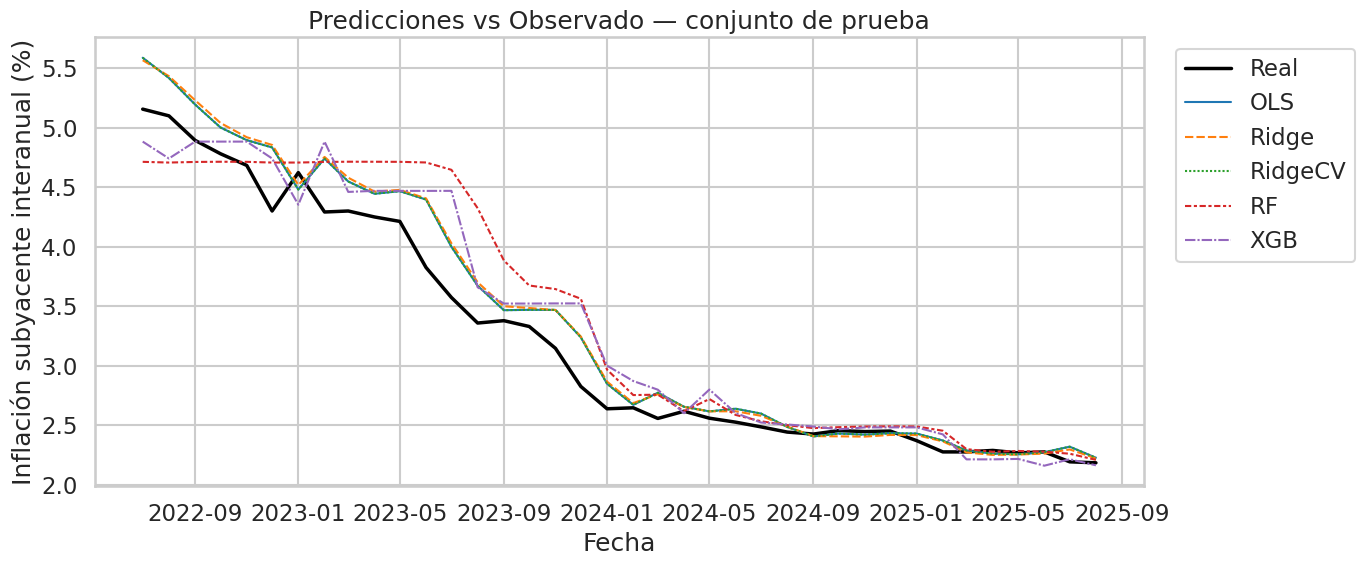

In [15]:
results = {
    'Baseline_Mean': (mse_base_mean, r2_base_mean),
    'Baseline_Persistence': (mse_persistence, r2_persistence),
    'OLS': (mse_ols_test, r2_ols_test),
    'Ridge_Grid': (mse_ridge_test, r2_ridge_test),
    'RidgeCV': (mean_squared_error(y_test, y_pred_ridgecv), r2_score(y_test, y_pred_ridgecv)),
    'RF': (mse_rf_test, r2_rf_test),
    'XGB': (mse_xgb_test, r2_xgb_test)
}
res_df = pd.DataFrame.from_dict(results, orient='index', columns=['Test_MSE','Test_R2'])
display(res_df.sort_values('Test_MSE'))

df_preds = pd.DataFrame({
    'Real': y_test,
    'OLS': y_pred_ols,
    'Ridge': y_pred_ridge,
    'RidgeCV': y_pred_ridgecv,
    'RF': y_pred_rf,
    'XGB': y_pred_xgb
}, index=y_test.index)

plt.figure(figsize=(14,6))
sns.lineplot(data=df_preds['Real'], label='Real', color='black', linewidth=2.5)
sns.lineplot(data=df_preds.drop(columns=['Real']), palette='tab10', linewidth=1.5)
plt.title('Predicciones vs Observado — conjunto de prueba')
plt.ylabel('Inflación subyacente interanual (%)')
plt.xlabel('Fecha')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

El gráfico presenta la evolución de la inflación subyacente interanual observada (línea negra) y las predicciones generadas por los distintos modelos durante el período de prueba. La serie muestra una tendencia descendente suave y altamente persistente, un patrón que influye claramente en el desempeño relativo de los modelos.

Los modelos lineales —OLS, Ridge y RidgeCV— son los que mejor reproducen la trayectoria real. Sus predicciones siguen casi exactamente la senda descendente de la inflación, lo que se refleja en sus valores de MSE y R², que se ubican muy cerca del modelo de persistencia. Esto indica que, en este horizonte, la relación entre los predictores y la inflación parece ser esencialmente lineal, sin señales fuertes de no linealidad que requieran mayor complejidad.

El modelo XGBoost logra capturar adecuadamente la dirección general de la serie, aunque con fluctuaciones ligeramente más pronunciadas que los modelos lineales. Esto se refleja en un error algo mayor, pero aun así mantiene un ajuste sólido.

Por otro lado, Random Forest muestra un menor desempeñO. Su estructura basada en árboles dificulta modelar una tendencia suave y persistente como la observada, por lo que aparece más ruidoso y con desviaciones claras respecto a la trayectoria real.

En conjunto, los resultados sugieren que, para este horizonte y dinámica inflacionaria, los modelos lineales —particularmente Ridge y OLS— ofrecen las predicciones más estables y precisas, mientras que los métodos no lineales no aportan mejoras significativas frente a un proceso dominado por la persistencia.

## 11. Diagnóstico gráfico — ACF/PACF de residuos (OLS)

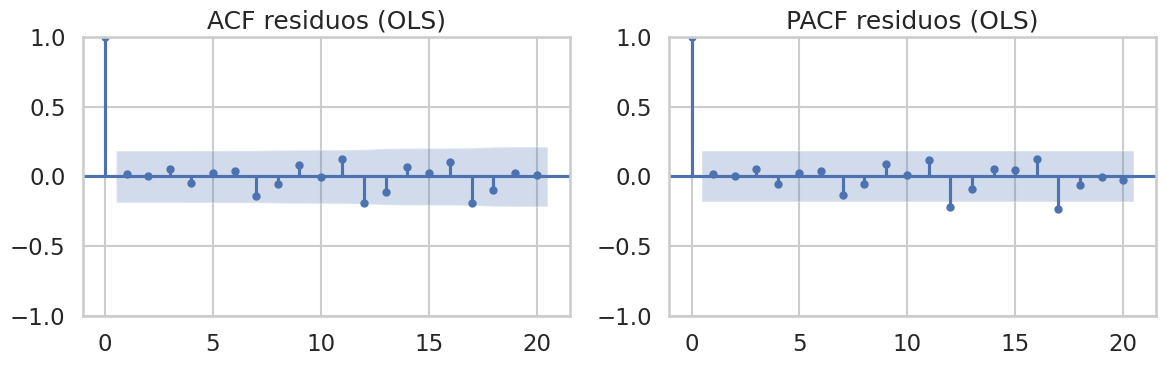

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
residuals = ols_final.resid
fig, axes = plt.subplots(1,2, figsize=(12,4))
plot_acf(residuals, lags=20, ax=axes[0])
plot_pacf(residuals, lags=20, ax=axes[1])
axes[0].set_title('ACF residuos (OLS)')
axes[1].set_title('PACF residuos (OLS)')
plt.tight_layout()
plt.show()

Los gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF) de los residuos muestran que, más allá del rezago 0, ninguna correlación supera los límites de significancia. Esto indica que los errores del modelo OLS son esencialmente ruido blanco, es decir, no presentan patrones temporales remanentes.

Desde un punto de vista predictivo, esto confirma que el modelo captura adecuadamente la dinámica temporal de la inflación subyacente, sin dejar estructura serial sin explicar. Esto sugiere que los rezagos de inflación, las expectativas y las tasas de interés incluidas explican gran parte de la persistencia del proceso inflacionario, logrando un modelo bien especificado para pronóstico.